In [108]:
#Imports
import time

import numpy as np
from scipy.stats import norm
import gurobipy as gb
import matplotlib.pyplot as plt

#Set seed for reproducibility of instances
np.random.seed(25)

def instance_generator(n=1500):
    '''
    Function that generates hard Knapsack problem instances.
    Input:
        -n: desired size of set of items I, defaulted at 50,000 as we use this number in our study
    Returns:
        -v: array of values for all i items
        -w: array of weights of all i items
    
    ''' 
    v = np.round(norm.rvs(100, 10, size=n))
    w = np.zeros(n)
    for i in range(n):
        w[i] = round(norm.rvs(v[i], 5))
    return v, w

v, w = instance_generator()

# Problem size set-up
N = [10, 25, 50, 100, 250, 500, 750, 1000, 1500]

# Capacity constraint function based on the problem size
def W(n):
    return 0.45*np.sum(w[0:n])

In [109]:
# Binary problem
def binary_method(n, v=v, w=w):
    '''
    Function that runs the Gurobi-binary problem.
    Input:
        -n: Input problem size
    Output:
        -obj_val: Outcome of the optimizatoin
        -running_time: Time to run the algorithm on the problem size
    '''
    # Selecting relevant i for problem size, and calculate knapsack capacity
    W_gb = int(W(n))

    start_time = time.perf_counter()

    m = gb.Model("Binary model")
    x = m.addVars(n, vtype=gb.GRB.BINARY, name="x")

    m.setObjective(gb.quicksum(v[i]*x[i] for i in range(n)), gb.GRB.MAXIMIZE)

    m.addConstr(gb.quicksum(w[i]*x[i] for i in range(n)) <= W_gb)

    m.update()
    m.Params.LogToConsole = 0
    m.optimize()
    
    obj_val = m.objVal
    running_time = time.perf_counter() - start_time
    # print(len([i for i in range(n) if x[i].X==1]))
    return obj_val, running_time    

In [110]:
#binary_method(50)

In [111]:
optimal_solution_binary = [binary_method(n)[0] for n in N]
running_time_binary = [binary_method(n)[1] for n in N]

In [112]:

# Dynamic programming
def dyn_prog_method(n, v=v, w=w):
    
    # Selecting relevant i for problem size, and calculate knapsack capacity
    W_dp = int(W(n))

    # Start runtime measurement
    start_time = time.perf_counter()

    # Create table for bottom up dynamic programming
    OPT_table = [[0 for i in range(W_dp+1)] for i in range(n+1)]
    
    
    for i in range(1, n+1):
        for j in range(1, W_dp+1):
            if w[i-1] <= j:
                OPT_table[i][j] = max(OPT_table[i-1][j], v[i-1]+ OPT_table[i-1][int(j-w[i-1])])
            else:
                OPT_table[i][j] = OPT_table[i-1][j]

    # End runtime measurement
    running_time = time.perf_counter() - start_time

    # Return the value in the knapsack and the running time
    return OPT_table[n][W_dp], running_time    


In [113]:
#dyn_prog_method(5000)

In [114]:
#dyn_prog_method(5000)
optimal_solution_dyn_prog = [dyn_prog_method(n)[0] for n in N]
running_time_dyn_prog = [dyn_prog_method(n)[1] for n in N]

In [115]:
dyn_prog_method(50)

(2338.0, 0.1038055999961216)

In [116]:

# Greedy Hueristic
def Greedy_method(n, v=v, w=w):
    
    # Selecting relevant i for problem size, and calculate knapsack capacity
    W_gy = int(W(n))

    # Start runtime measurement
    start_time = time.perf_counter()

    # Calculate ratios
    ratios = [(v[i] /w[i], v[i], w[i]) for i in range(n) ]
    
    ratios.sort(reverse=True)

    # to 
    Weight_in_knapsack = 0
    value_in_knapsack = 0

    for ratio, value, weight in ratios:
        if Weight_in_knapsack + weight <= W_gy:
            value_in_knapsack += value
            Weight_in_knapsack += weight

    # End runtime measurement
    running_time = time.perf_counter() - start_time

    # Return the value in the knapsack and the running time
    return value_in_knapsack, running_time    


In [117]:
optimal_solution_greedy = [Greedy_method(n)[0] for n in N]
running_time_greedy = [Greedy_method(n)[1] for n in N]

In [118]:
#Greedy_method(50)

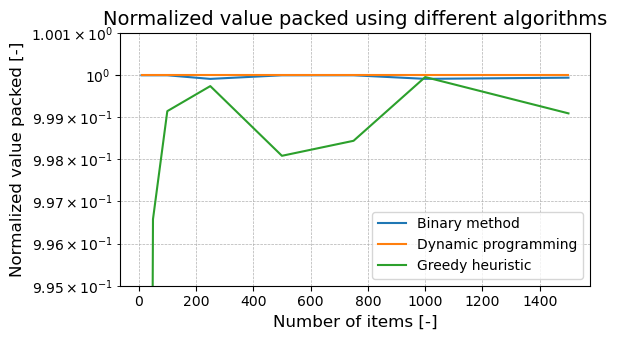

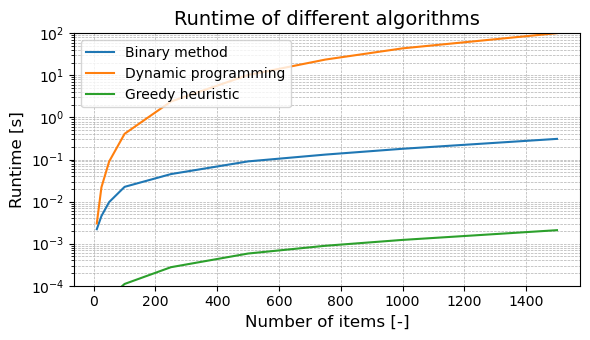

In [121]:
plt.figure(figsize=(6, 3.5))
plt.plot(N, [(optimal_solution_binary[i] /optimal_solution_dyn_prog[i]) for i in range(len(N))], label='Binary method', linestyle='-')
plt.plot(N, [[1] for i in range(len(N))], label='Dynamic programming', linestyle='-')
plt.plot(N, [(optimal_solution_greedy[i] /optimal_solution_dyn_prog[i]) for i in range(len(N))], label='Greedy heuristic', linestyle='-')

plt.xlabel('Number of items [-]', fontsize=12)
plt.ylabel('Normalized value packed [-]', fontsize=12)
plt.title('Normalized value packed using different algorithms', fontsize=14)
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.ylim(0.995, 1.001)
plt.show()

plt.figure(figsize=(6, 3.5))
plt.plot(N, running_time_binary, label='Binary method', linestyle='-')
plt.plot(N, running_time_dyn_prog, label='Dynamic programming', linestyle='-')
plt.plot(N, running_time_greedy, label='Greedy heuristic', linestyle='-')

plt.xlabel('Number of items [-]', fontsize=12)
plt.ylabel('Runtime [s]', fontsize=12)
plt.title('Runtime of different algorithms', fontsize=14)
plt.yscale('log')
plt.legend(loc='upper left')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.ylim(0.0001, 100)
plt.show()

In [120]:
print(optimal_solution_binary,optimal_solution_dyn_prog, optimal_solution_greedy)
print(running_time_binary,running_time_dyn_prog, running_time_greedy)

[439.0, 1159.0, 2338.0, 4686.0, 11661.0, 23488.0, 35279.0, 47159.0, 70592.0] [439.0, 1159.0, 2338.0, 4686.0, 11662.0, 23488.0, 35279.0, 47163.0, 70596.0] [418.0, 1112.0, 2330.0, 4682.0, 11659.0, 23443.0, 35224.0, 47161.0, 70532.0]
[0.002207999990787357, 0.004537999979220331, 0.009742800000822172, 0.022418500011553988, 0.045057699986500666, 0.09032360001583584, 0.13103879999835044, 0.18017139998846687, 0.309731199988164] [0.003035899979295209, 0.02191599999787286, 0.08987280001747422, 0.4089592999953311, 2.391361899994081, 10.222636399994371, 23.77709909999976, 43.941280899976846, 101.0012693000026] [1.829999382607639e-05, 2.929999027401209e-05, 5.2799994591623545e-05, 0.00011019999510608613, 0.0002756999747361988, 0.0005824999825563282, 0.0008908000017981976, 0.0012280000082682818, 0.002091300004394725]
